<a href="https://colab.research.google.com/github/Mr-sri-ganesh/html/blob/main/transformer(working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy pandas tensorflow scikit-learn matplotlib


Saving CGM_14days_sample.csv to CGM_14days_sample (1).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (1).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (1).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (1).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (1).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (1).csv
Epoch 20, Loss: 1.1819
Epoch 40, Loss: 1.0431
Epoch 60, Loss: 1.0252
Epoch 80, Loss: 1.0433
Epoch 100, Loss: 0.9018
Epoch 120, Loss: 0.8714
Epoch 140, Loss: 1.1005
Epoch 160, Loss: 1.0641
Epoch 180, Loss: 1.1965
Epoch 200, Loss: 1.0177


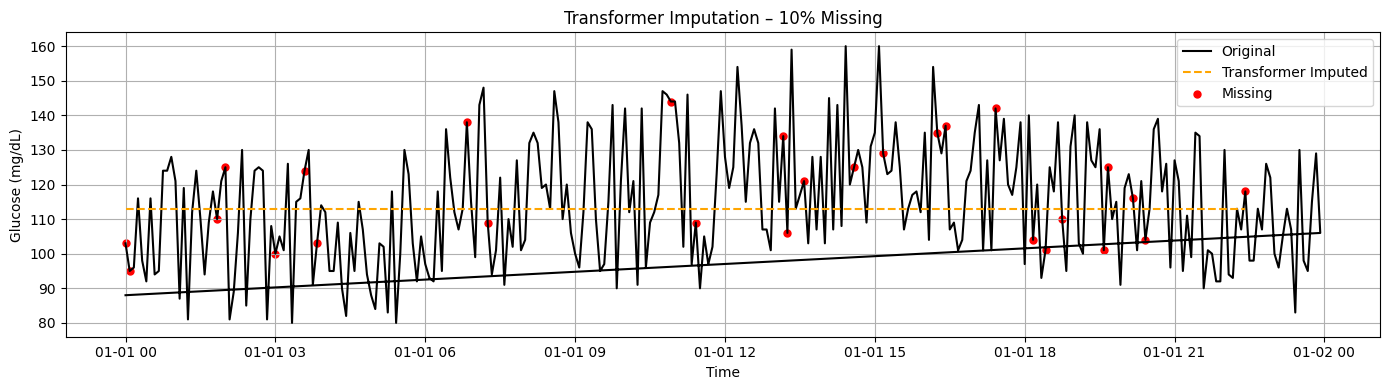

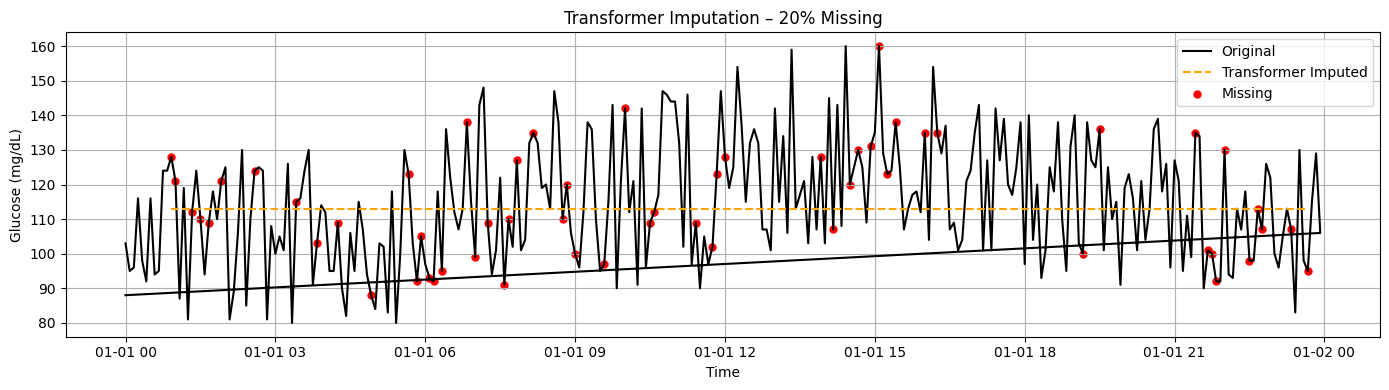

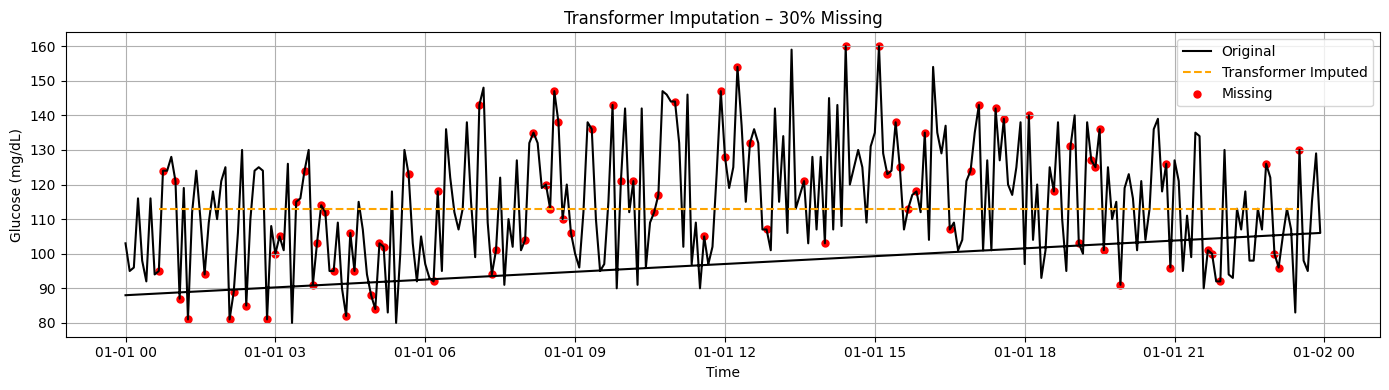

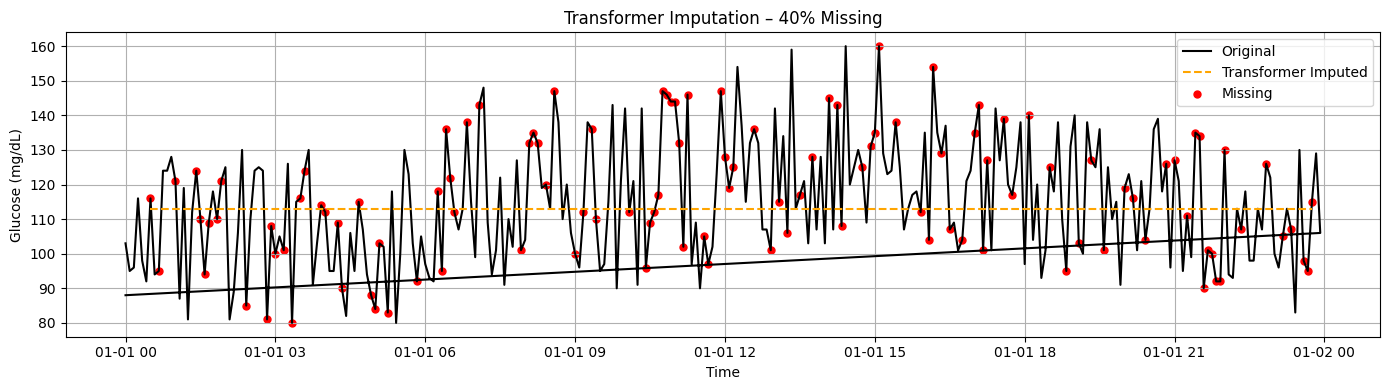


📊 Transformer Imputation Evaluation:


Missingness        MAE       RMSE       MAPE        MAD        MRD
0  10% Missing  12.778919  15.011394  10.549773  12.778919  10.549773
1  20% Missing  13.348231  15.951648  11.654690  13.348231  11.654690
2  30% Missing  16.815186  19.910695  14.970528  16.815186  14.970528
3  40% Missing  15.096058  18.339612  12.990761  15.096058  12.990761

In [ ]:
# ✅ Transformer-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 2: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 3: Load and normalize data
def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file)
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p', errors='coerce')

    values = df['Blood Sugar Level'].values.astype(float)
    mask = ~np.isnan(values)
    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    norm = np.nan_to_num(norm, nan=0.0)

    return norm, mask.astype(float), mean, std, df['Time'].values

def to_tensor(data, mask):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device)

# STEP 4: Transformer Imputation Model
class TransformerImputer(nn.Module):
    def __init__(self, input_size=1, d_model=64, n_heads=4, num_layers=2):
        super(TransformerImputer, self).__init__()
        self.embedding = nn.Linear(input_size * 2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_size)

    def forward(self, x, mask):
        inp = torch.cat([x, mask], dim=2)
        emb = self.embedding(inp)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 5: Training with simulated block masking
import random

def simulate_block_mask(mask, block_size=12):
    new_mask = mask.copy()
    for _ in range(5):
        start = random.randint(0, len(mask) - block_size)
        new_mask[start:start+block_size] = 0
    return new_mask

def train_model(model, x_full, mask_full, epochs=200):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        train_mask = mask_full.clone().squeeze(0).squeeze(1).cpu().numpy()
        train_mask = simulate_block_mask(train_mask)
        train_mask = torch.tensor(train_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 6: Evaluation

def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor = to_tensor(x_raw, mask)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    missing = mask == 0
    known = ~missing
    pred[known] = y_true[known]

    y_missing = y_true[missing]
    p_missing = pred[missing]

    if len(y_missing) == 0:
        print(f"\u26a0\ufe0f Skipping {label} – no valid missing data to evaluate.")
        return {'Missingness': label, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'MAD': np.nan, 'MRD': np.nan}

    mae = mean_absolute_error(y_missing, p_missing)
    rmse = np.sqrt(mean_squared_error(y_missing, p_missing))
    mape = mean_absolute_percentage_error(y_missing, p_missing)
    mad = np.mean(np.abs(y_missing - p_missing))
    mrd = np.mean(np.abs((y_missing - p_missing) / y_missing))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black', linewidth=1.5)
    plt.plot(time_axis[missing], pred[missing], label='Transformer Imputed', color='orange', linestyle='--', linewidth=1.5)
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"Transformer Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 7: Run Training + Imputation
train_data, train_mask, mean, std, _ = load_sequence("CGM_single_day_2025-06-27.csv")
x_train, m_train = to_tensor(train_data, train_mask)
model = TransformerImputer().to(device)
train_model(model, x_train, m_train)

# STEP 8: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    try:
        result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
        results.append(result)
    except Exception as e:
        print(f"Skipping {file} due to error: {e}")

results_df = pd.DataFrame(results)
print("\n📊 Transformer Imputation Evaluation:")
display(results_df)


Saving CGM_14days_sample.csv to CGM_14days_sample (5).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (5).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (5).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (5).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (5).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (5).csv
Epoch 20, Loss: 0.9901
Epoch 40, Loss: 1.1700
Epoch 60, Loss: 1.0537
Epoch 80, Loss: 1.1030
Epoch 100, Loss: 1.1390
Epoch 120, Loss: 1.1155
Epoch 140, Loss: 1.1095
Epoch 160, Loss: 0.7597
Epoch 180, Loss: 1.2231
Epoch 200, Loss: 0.9408


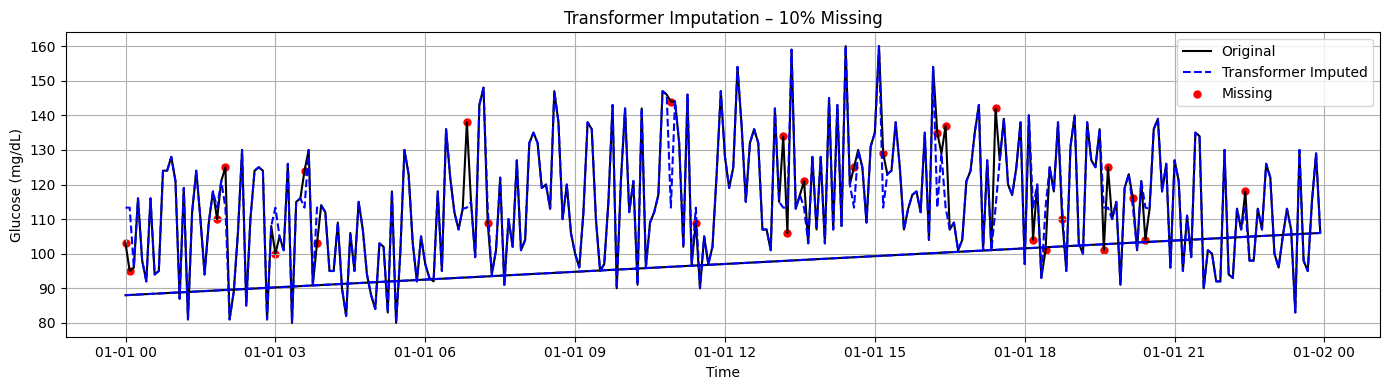

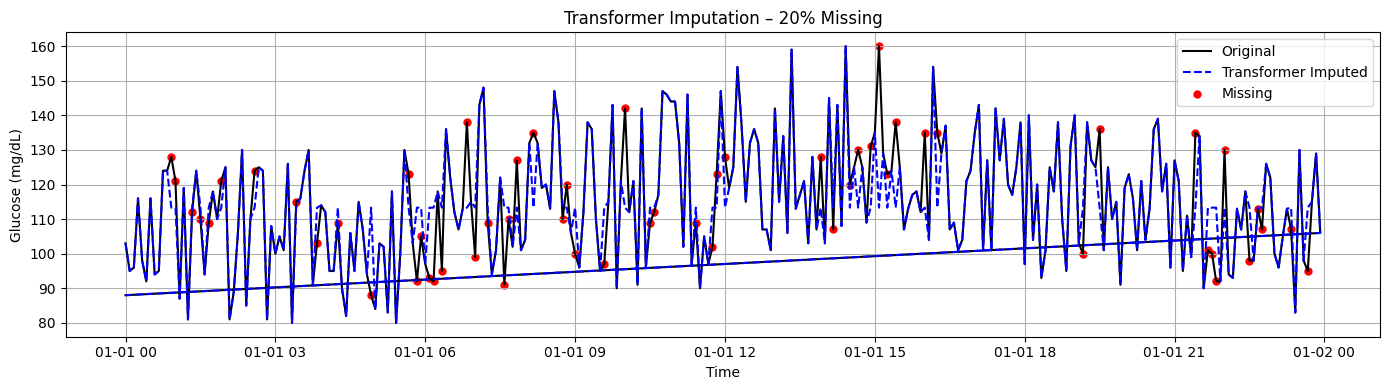

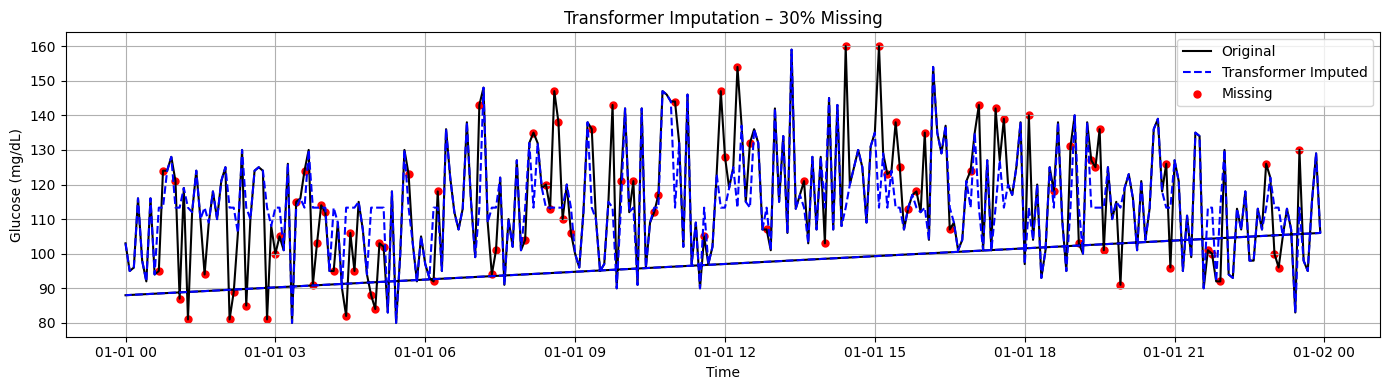

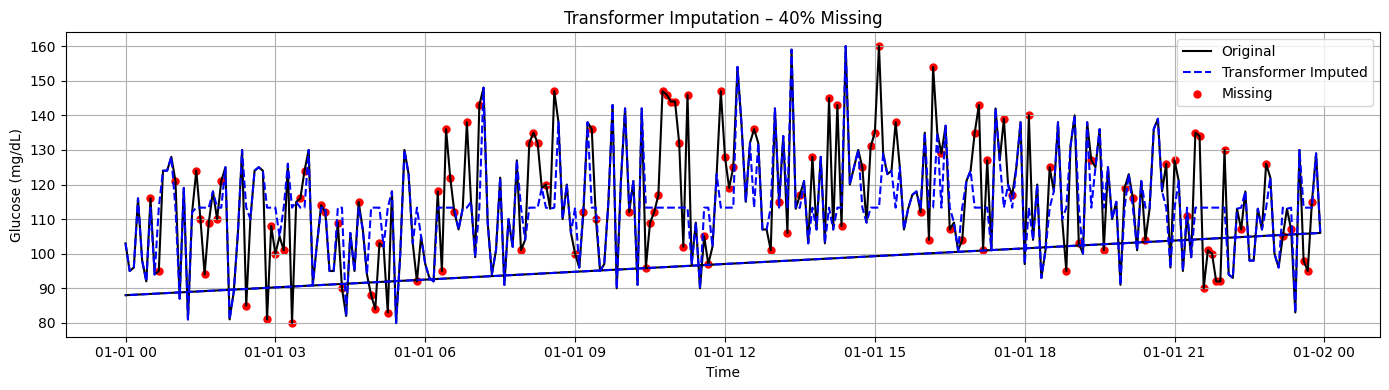


📊 Transformer Imputation Evaluation:


Missingness        MAE       RMSE       MAPE        MAD        MRD
0  10% Missing  12.766062  14.914174  10.570809  12.766062  10.570809
1  20% Missing  13.389697  15.923880  11.727116  13.389697  11.727116
2  30% Missing  16.813953  19.885176  15.014800  16.813953  15.014800
3  40% Missing  15.081928  18.282450  13.015620  15.081928  13.015620

In [ ]:
# ✅ Colab-ready Transformer-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Load and normalize data

def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file, na_values=["", " "])
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p', errors='coerce')

    values = df['Blood Sugar Level'].values.astype(float)
    mask = ~np.isnan(values)

    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    norm = np.nan_to_num(norm, nan=0.0)

    return norm, mask.astype(float), mean, std, df['Time'].values

def to_tensor(data, mask):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device)

# STEP 5: Define Transformer model
class TransformerImputer(nn.Module):
    def __init__(self, input_size=1, d_model=128, n_heads=4, num_layers=4):
        super(TransformerImputer, self).__init__()
        self.embedding = nn.Linear(input_size * 2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_size)

    def forward(self, x, mask):
        inp = torch.cat([x, mask], dim=2)
        emb = self.embedding(inp)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 6: Train function with block missingness
import random

def simulate_block_mask(mask, block_size=12):
    new_mask = mask.copy()
    for _ in range(5):
        start = random.randint(0, len(mask) - block_size)
        new_mask[start:start+block_size] = 0
    return new_mask

def train_model(model, x_full, mask_full, epochs=200):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        train_mask = mask_full.clone().squeeze(0).squeeze(1).cpu().numpy()
        train_mask = simulate_block_mask(train_mask)
        train_mask = torch.tensor(train_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 7: Evaluate function

def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor = to_tensor(x_raw, mask)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    missing = mask == 0
    known = ~missing

    pred[known] = y_true[known]

    y_missing = y_true[missing]
    p_missing = pred[missing]

    if len(y_missing) == 0:
        print(f"⚠️ Skipping {label} – no valid missing data to evaluate.")
        return {'Missingness': label, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'MAD': np.nan, 'MRD': np.nan}

    mae = mean_absolute_error(y_missing, p_missing)
    rmse = np.sqrt(mean_squared_error(y_missing, p_missing))
    mape = mean_absolute_percentage_error(y_missing, p_missing)
    mad = np.mean(np.abs(y_missing - p_missing))
    mrd = np.mean(np.abs((y_missing - p_missing) / y_missing))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black')
    plt.plot(time_axis, pred, label='Transformer Imputed', color='blue', linestyle='--')
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"Transformer Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 8: Run Training + Imputation
train_data, train_mask, mean, std, _ = load_sequence("CGM_single_day_2025-06-27.csv")
x_train, m_train = to_tensor(train_data, train_mask)
model = TransformerImputer().to(device)
train_model(model, x_train, m_train)

# STEP 9: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    try:
        result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
        results.append(result)
    except ValueError as e:
        print(f"Skipping {file} due to evaluation error: {e}")

results_df = pd.DataFrame(results)
print("\n📊 Transformer Imputation Evaluation:")
display(results_df)


Saving CGM_14days_sample.csv to CGM_14days_sample (2).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (2).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (2).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (2).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (2).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (2).csv


/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To en

Epoch 20, Loss: 1.0367
Epoch 40, Loss: 1.0415
Epoch 60, Loss: 1.0402
Epoch 80, Loss: 0.9561
Epoch 100, Loss: 0.8900
Epoch 120, Loss: 0.9144
Epoch 140, Loss: 0.8709
Epoch 160, Loss: 0.8738
Epoch 180, Loss: 0.8015
Epoch 200, Loss: 0.8006
Epoch 220, Loss: 0.8016
Epoch 240, Loss: 0.8117
Epoch 260, Loss: 0.8289
Epoch 280, Loss: 0.8032
Epoch 300, Loss: 0.7865


/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


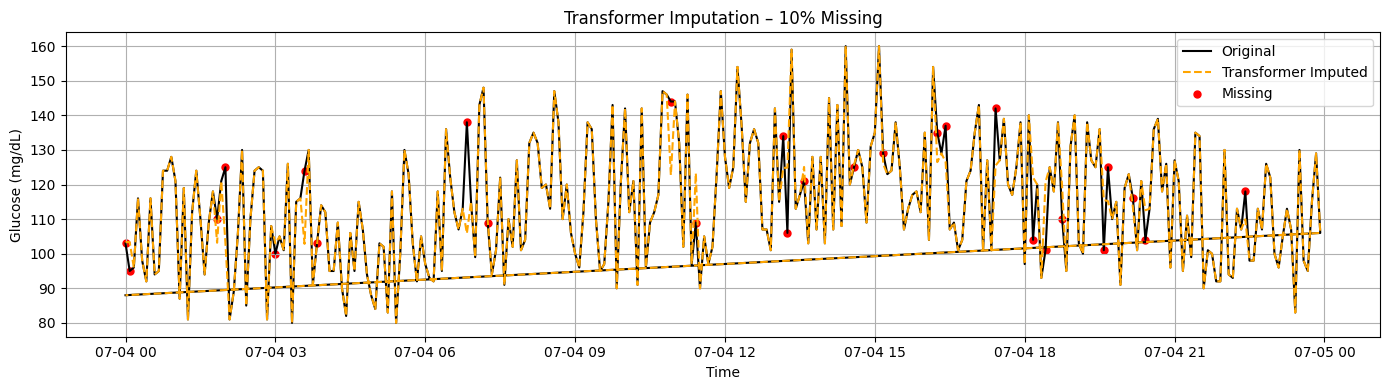

/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


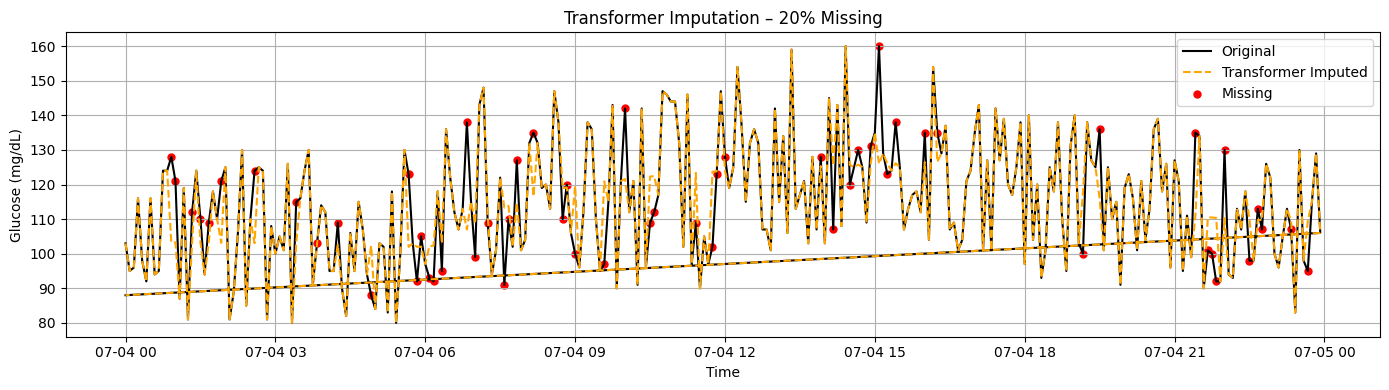

/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


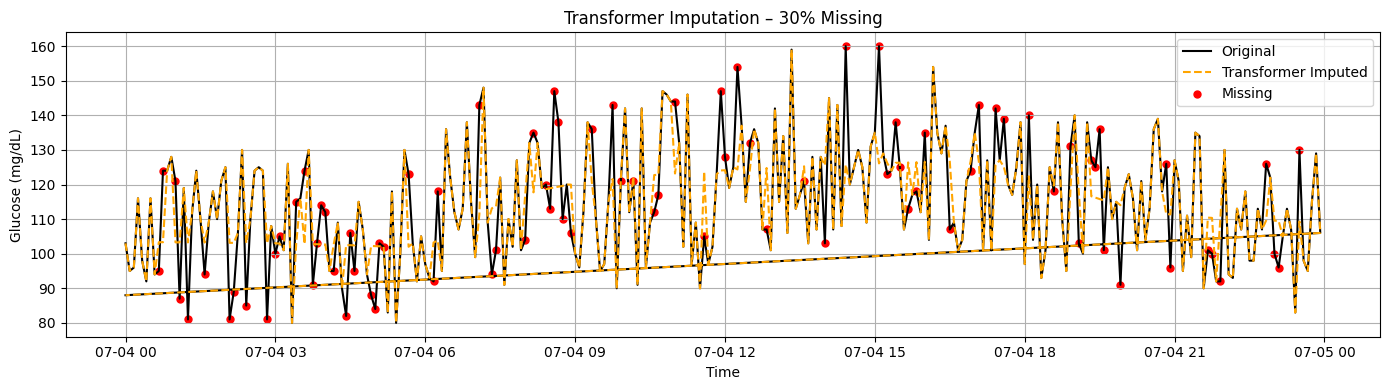

/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-3-2242012485.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


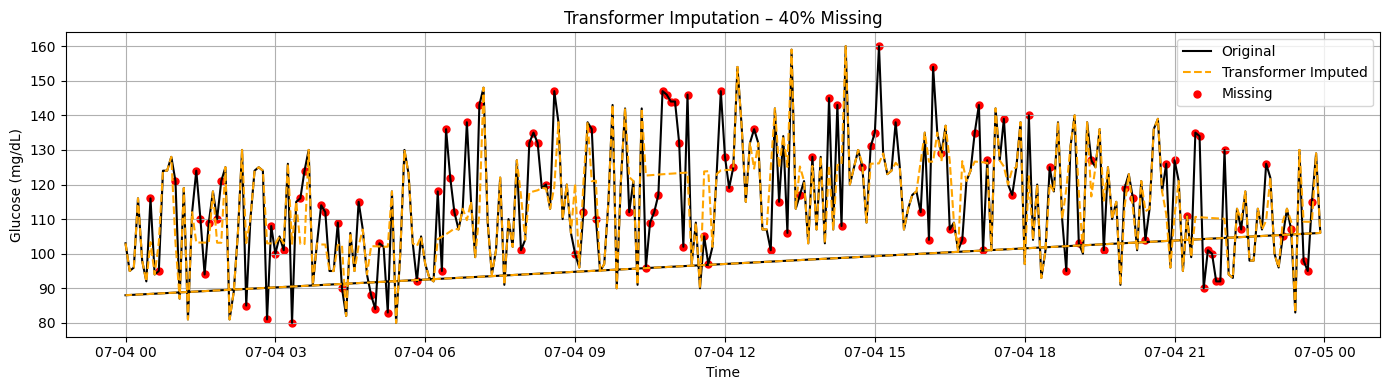


📊 Transformer Imputation Evaluation:


Missingness        MAE       RMSE       MAPE        MAD        MRD
0  10% Missing  10.825106  13.489334   9.126222  10.825106   9.126222
1  20% Missing  12.134502  14.511418  10.651582  12.134502  10.651582
2  30% Missing  13.604170  15.712235  12.067087  13.604170  12.067087
3  40% Missing  13.907049  15.982579  12.155293  13.907049  12.155293

In [ ]:
# ✅ Colab-ready Transformer-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Load and normalize data

def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file, na_values=["", " "])
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

    df = df.dropna(subset=['Time'])  # Remove invalid time rows

    values = df['Blood Sugar Level'].values.astype(float)
    time_of_day = df['Time'].dt.hour * 60 + df['Time'].dt.minute
    time_norm = time_of_day / 1440.0  # Normalize by minutes per day

    mask = ~np.isnan(values)

    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    norm = np.nan_to_num(norm, nan=0.0)

    return norm, mask.astype(float), time_norm, mean, std, df['Time'].values

def to_tensor(data, mask, time_norm):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    t = torch.tensor(time_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device), t.to(device)

# STEP 5: Define Transformer model with Positional + Time Feature Encoding
class TransformerImputer(nn.Module):
    def __init__(self, input_size=1, d_model=128, n_heads=4, num_layers=4):
        super(TransformerImputer, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_size * 3, d_model),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, input_size)
        )

    def forward(self, x, mask, time_norm):
        inp = torch.cat([x, mask, time_norm], dim=2)
        emb = self.embedding(inp)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 6: Train using real missing patterns

def combine_masks(files, mean, std):
    combined_mask = None
    for f in files:
        _, mask, _, _, _, _ = load_sequence(f, mean, std)
        if combined_mask is None:
            combined_mask = mask
        else:
            combined_mask = np.minimum(combined_mask, mask)
    return combined_mask.astype(float)

def train_model(model, x_full, full_mask, time_norm_full, epochs=300):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
    loss_fn = nn.MSELoss()

    train_mask = torch.tensor(full_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

    for epoch in range(epochs):
        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask, time_norm_full)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 7: Evaluate function

def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, time_norm, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor, t_tensor = to_tensor(x_raw, mask, time_norm)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor, t_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    missing = mask == 0
    known = ~missing

    pred[known] = y_true[known]

    y_missing = y_true[missing]
    p_missing = pred[missing]

    if len(y_missing) == 0:
        print(f"⚠️ Skipping {label} – no valid missing data to evaluate.")
        return {'Missingness': label, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'MAD': np.nan, 'MRD': np.nan}

    mae = mean_absolute_error(y_missing, p_missing)
    rmse = np.sqrt(mean_squared_error(y_missing, p_missing))
    mape = mean_absolute_percentage_error(y_missing, p_missing)
    mad = np.mean(np.abs(y_missing - p_missing))
    mrd = np.mean(np.abs((y_missing - p_missing) / y_missing))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black')
    plt.plot(time_axis, pred, label='Transformer Imputed', color='orange', linestyle='--')
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"Transformer Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 8: Run Training + Imputation
train_data, train_mask, time_norm, mean, std, _ = load_sequence("CGM_single_day_2025-06-27.csv")
x_train, m_train, t_train = to_tensor(train_data, train_mask, time_norm)
real_missing_files = ["CGM_single_day_missing_10.csv", "CGM_single_day_missing_20.csv", "CGM_single_day_missing_30.csv", "CGM_single_day_missing_40.csv"]
real_mask = combine_masks(real_missing_files, mean, std)
model = TransformerImputer().to(device)
train_model(model, x_train, real_mask, t_train)

# STEP 9: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    try:
        result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
        results.append(result)
    except ValueError as e:
        print(f"Skipping {file} due to evaluation error: {e}")

results_df = pd.DataFrame(results)
print("\n📊 Transformer Imputation Evaluation:")
display(results_df)


Saving CGM_14days_sample.csv to CGM_14days_sample (1).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (1).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (1).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (1).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (1).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (1).csv


/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To en

Epoch 20, Loss: 1.0669
Epoch 40, Loss: 1.0499
Epoch 60, Loss: 1.0312
Epoch 80, Loss: 1.0150
Epoch 100, Loss: 1.0670
Epoch 120, Loss: 1.0514
Epoch 140, Loss: 1.0440
Epoch 160, Loss: 1.0280
Epoch 180, Loss: 1.0427
Epoch 200, Loss: 1.0715
Epoch 220, Loss: 1.0362
Epoch 240, Loss: 1.0548
Epoch 260, Loss: 1.0377
Epoch 280, Loss: 1.0413
Epoch 300, Loss: 1.0442
Epoch 320, Loss: 1.0626
Epoch 340, Loss: 1.0552
Epoch 360, Loss: 1.0645
Epoch 380, Loss: 1.0488
Epoch 400, Loss: 1.0508


/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


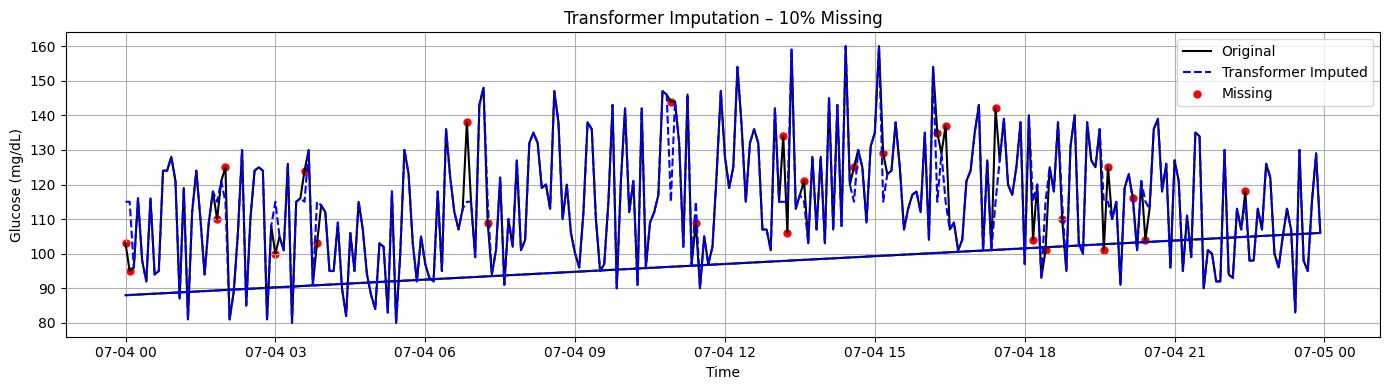

/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


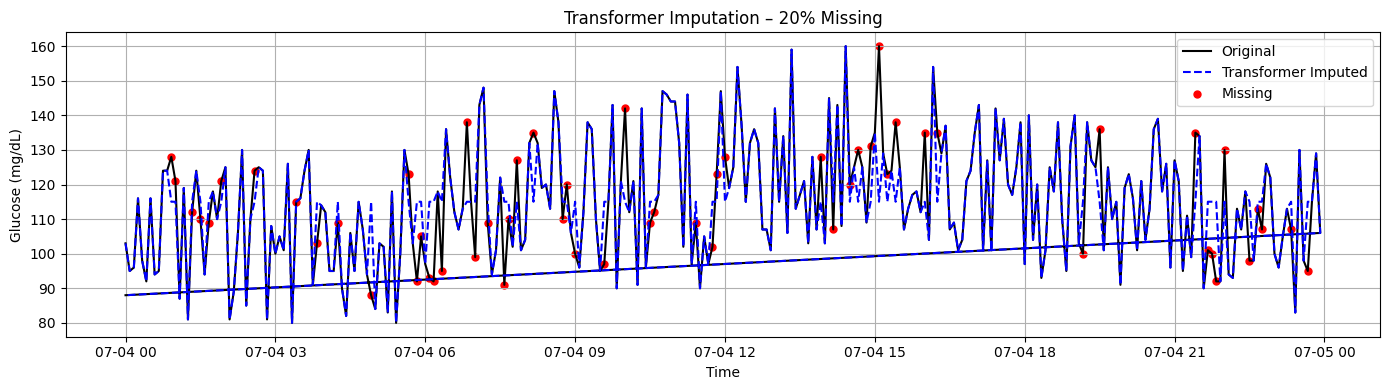

/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


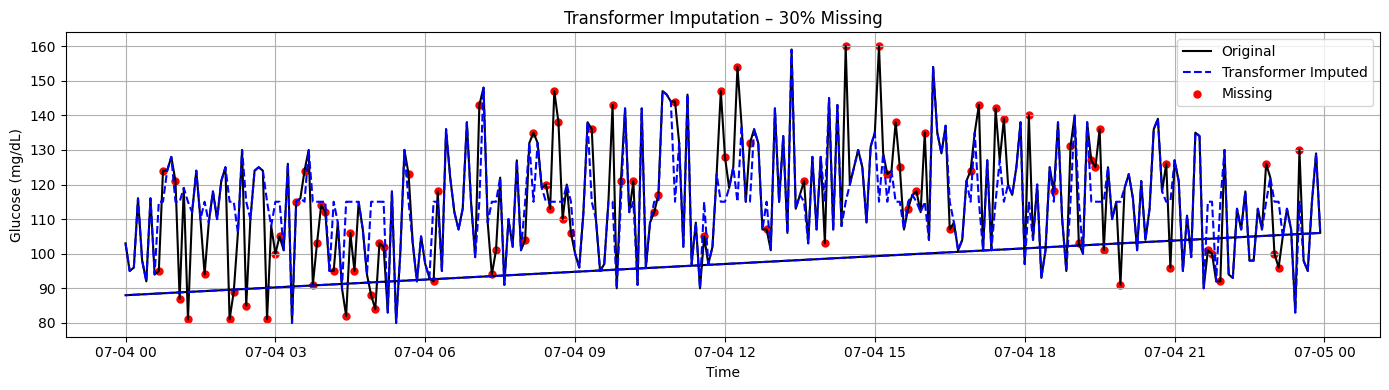

/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-2-1227834642.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


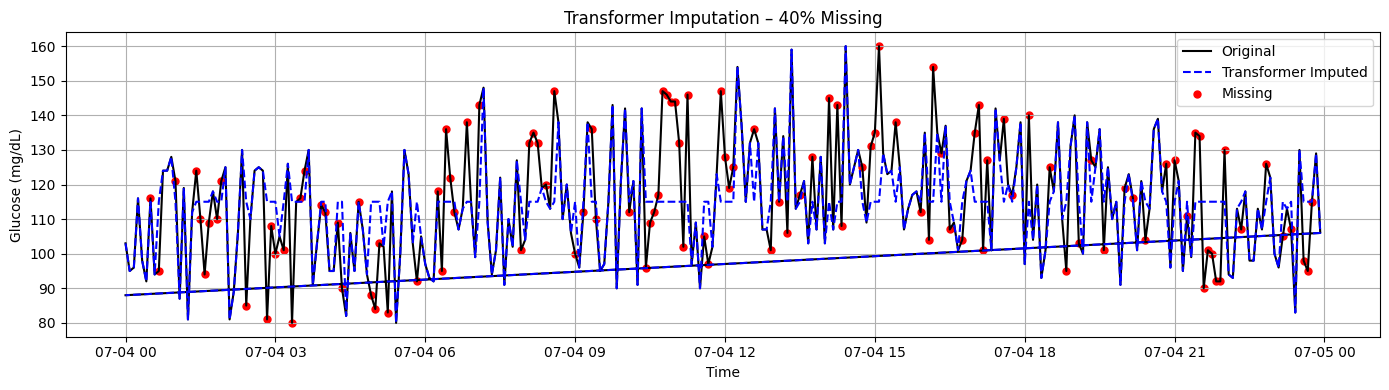


📊 Imputation Accuracy Summary (MAE, RMSE, MAPE):


Missingness        MAE       RMSE       MAPE
0  10% Missing  12.702129  14.546764  10.673763
1  20% Missing  13.600269  15.896745  12.089777
2  30% Missing  16.837526  19.844853  15.261848
3  40% Missing  15.026474  18.074813  13.162912


📊 Mean Absolute Deviation (MAD) and Mean Relative Deviation (MRD):


Missingness        MAD        MRD
0  10% Missing  12.702129  10.673763
1  20% Missing  13.600269  12.089777
2  30% Missing  16.837526  15.261848
3  40% Missing  15.026474  13.162912

In [ ]:
# ✅ Colab-ready Transformer-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Load and normalize data

def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file, na_values=["", " "])
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df.dropna(subset=['Time'])

    values = df['Blood Sugar Level'].values.astype(float)
    time_of_day = df['Time'].dt.hour * 60 + df['Time'].dt.minute
    time_norm = time_of_day / 1440.0

    mask = ~np.isnan(values)

    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    norm = np.nan_to_num(norm, nan=0.0)

    return norm, mask.astype(float), time_norm, mean, std, df['Time'].values

def to_tensor(data, mask, time_norm):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    t = torch.tensor(time_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device), t.to(device)

# STEP 5: Transformer Imputer (simplified for accuracy)
class TransformerImputer(nn.Module):
    def __init__(self, input_size=1, d_model=128, n_heads=4, num_layers=4):
        super(TransformerImputer, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_size * 3, d_model),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_size)

    def forward(self, x, mask, time_norm):
        inp = torch.cat([x, mask, time_norm], dim=2)
        emb = self.embedding(inp)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 6: Training with real missing patterns
def combine_masks(files, mean, std):
    combined_mask = None
    for f in files:
        _, mask, _, _, _, _ = load_sequence(f, mean, std)
        if combined_mask is None:
            combined_mask = mask
        else:
            combined_mask = np.minimum(combined_mask, mask)
    return combined_mask.astype(float)

def train_model(model, x_full, full_mask, time_norm_full, epochs=400):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=20)
    loss_fn = nn.MSELoss()

    train_mask = torch.tensor(full_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

    best_loss = float('inf')
    for epoch in range(epochs):
        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask, time_norm_full)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step(loss)

        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), 'best_transformer_model.pth')

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 7: Evaluate function

def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, time_norm, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor, t_tensor = to_tensor(x_raw, mask, time_norm)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor, t_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    missing = mask == 0
    known = ~missing
    pred[known] = y_true[known]

    y_missing = y_true[missing]
    p_missing = pred[missing]

    if len(y_missing) == 0:
        print(f"⚠️ Skipping {label} – no valid missing data to evaluate.")
        return {'Missingness': label, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'MAD': np.nan, 'MRD': np.nan}

    mae = mean_absolute_error(y_missing, p_missing)
    rmse = np.sqrt(mean_squared_error(y_missing, p_missing))
    mape = mean_absolute_percentage_error(y_missing, p_missing)
    mad = np.mean(np.abs(y_missing - p_missing))
    mrd = np.mean(np.abs((y_missing - p_missing) / y_missing))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black')
    plt.plot(time_axis, pred, label='Transformer Imputed', color='blue', linestyle='--')
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"Transformer Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 8: Run Training + Imputation
train_data, train_mask, time_norm, mean, std, _ = load_sequence("CGM_single_day_2025-06-27.csv")
x_train, m_train, t_train = to_tensor(train_data, train_mask, time_norm)
real_missing_files = [
    "CGM_single_day_missing_10.csv",
    "CGM_single_day_missing_20.csv",
    "CGM_single_day_missing_30.csv",
    "CGM_single_day_missing_40.csv"
]
real_mask = combine_masks(real_missing_files, mean, std)
model = TransformerImputer().to(device)
train_model(model, x_train, real_mask, t_train)
model.load_state_dict(torch.load('best_transformer_model.pth'))

# STEP 9: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    try:
        result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
        results.append(result)
    except ValueError as e:
        print(f"Skipping {file} due to evaluation error: {e}")

results_df = pd.DataFrame(results)

# Display metrics in two separate tables
print("\n📊 Imputation Accuracy Summary (MAE, RMSE, MAPE):")
display(results_df[['Missingness', 'MAE', 'RMSE', 'MAPE']])

print("\n📊 Mean Absolute Deviation (MAD) and Mean Relative Deviation (MRD):")
display(results_df[['Missingness', 'MAD', 'MRD']])


Saving CGM_14days_sample.csv to CGM_14days_sample (3).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (3).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (3).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (3).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (3).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (3).csv


/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To en

Epoch 20, Loss: 1.0276
Epoch 40, Loss: 0.8819
Epoch 60, Loss: 0.8770
Epoch 80, Loss: 0.8657
Epoch 100, Loss: 0.8228
Epoch 120, Loss: 0.7971
Epoch 140, Loss: 0.8001
Epoch 160, Loss: 0.8057
Epoch 180, Loss: 0.7895
Epoch 200, Loss: 0.8263
Epoch 220, Loss: 0.7859
Epoch 240, Loss: 0.7883
Epoch 260, Loss: 0.7673
Epoch 280, Loss: 0.7878
Epoch 300, Loss: 0.7842


/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


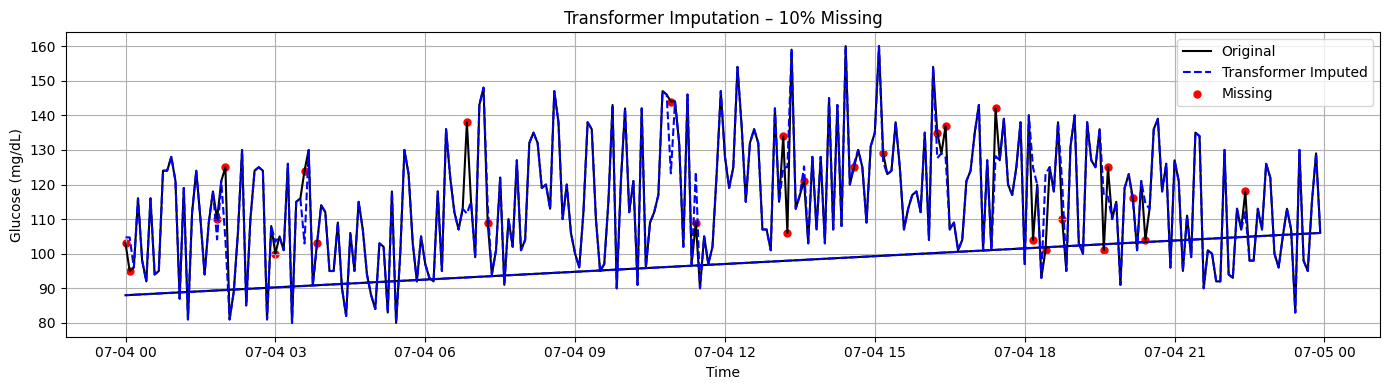

/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


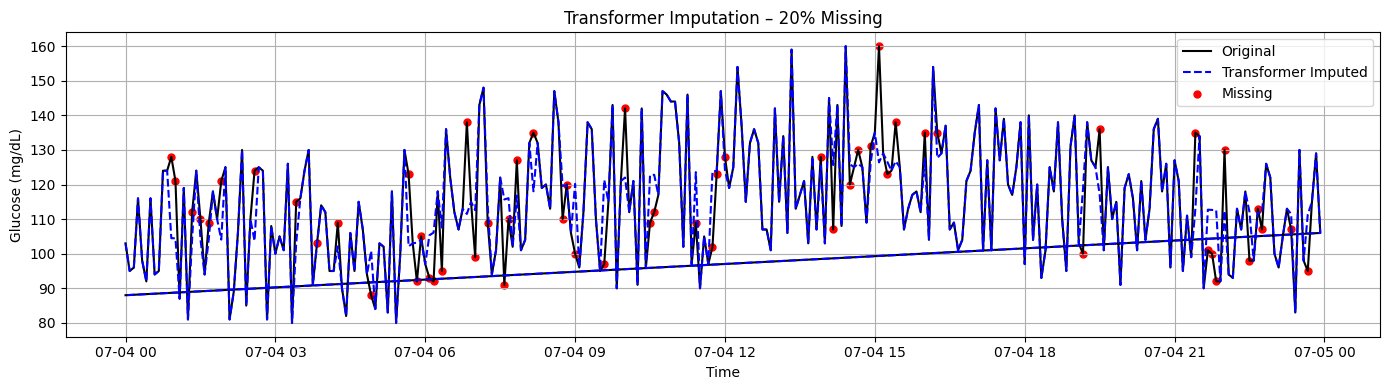

/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


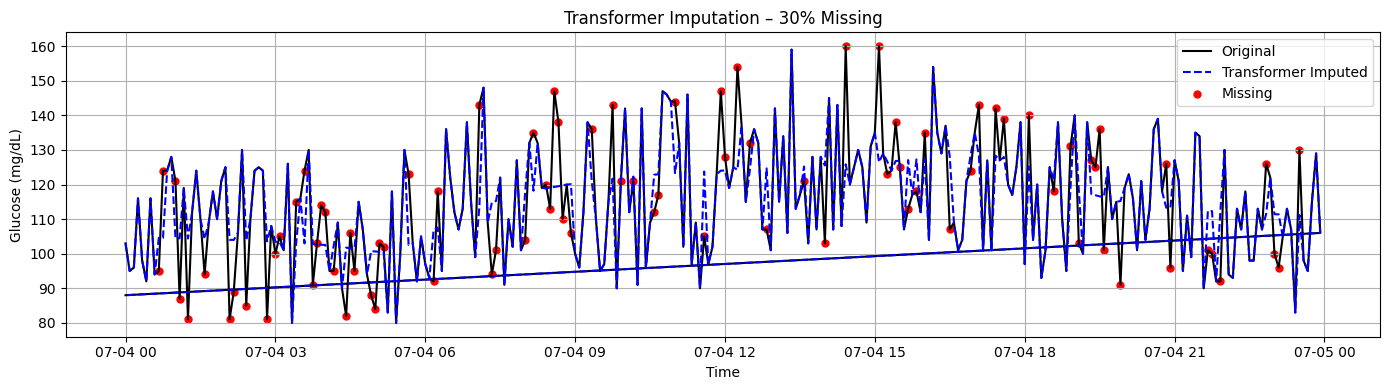

/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
/tmp/ipython-input-4-4021861520.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


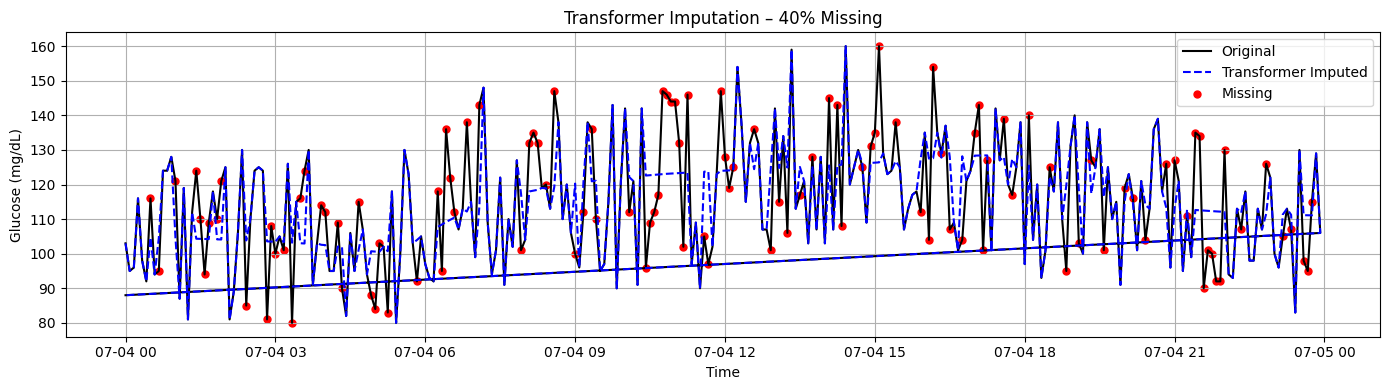


📊 Transformer Imputation Evaluation:


Missingness        MAE       RMSE       MAPE        MAD        MRD
0  10% Missing  10.780548  13.177646   9.218296  10.780548   9.218296
1  20% Missing  12.359233  14.534543  10.988573  12.359233  10.988573
2  30% Missing  13.666331  15.672565  12.214425  13.666331  12.214425
3  40% Missing  13.780189  15.811004  12.128223  13.780189  12.128223

In [ ]:
# ✅ Colab-ready Transformer-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Load and normalize data

def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file, na_values=["", " "])
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

    df = df.dropna(subset=['Time'])  # Remove invalid time rows

    values = df['Blood Sugar Level'].values.astype(float)
    time_of_day = df['Time'].dt.hour * 60 + df['Time'].dt.minute
    time_norm = time_of_day / 1440.0  # Normalize by minutes per day

    mask = ~np.isnan(values)

    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    norm = np.nan_to_num(norm, nan=0.0)

    return norm, mask.astype(float), time_norm, mean, std, df['Time'].values

def to_tensor(data, mask, time_norm):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    t = torch.tensor(time_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device), t.to(device)

# STEP 5: Define Transformer model with Positional + Time Feature Encoding
class TransformerImputer(nn.Module):
    def __init__(self, input_size=1, d_model=128, n_heads=4, num_layers=4):
        super(TransformerImputer, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_size * 3, d_model),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, input_size)
        )

    def forward(self, x, mask, time_norm):
        inp = torch.cat([x, mask, time_norm], dim=2)
        emb = self.embedding(inp)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 6: Train using real missing patterns

def combine_masks(files, mean, std):
    combined_mask = None
    for f in files:
        _, mask, _, _, _, _ = load_sequence(f, mean, std)
        if combined_mask is None:
            combined_mask = mask
        else:
            combined_mask = np.minimum(combined_mask, mask)
    return combined_mask.astype(float)

def train_model(model, x_full, full_mask, time_norm_full, epochs=300):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
    loss_fn = nn.MSELoss()

    train_mask = torch.tensor(full_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

    for epoch in range(epochs):
        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask, time_norm_full)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 7: Evaluate function

def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, time_norm, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor, t_tensor = to_tensor(x_raw, mask, time_norm)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor, t_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    missing = mask == 0
    known = ~missing

    pred[known] = y_true[known]

    y_missing = y_true[missing]
    p_missing = pred[missing]

    if len(y_missing) == 0:
        print(f"⚠️ Skipping {label} – no valid missing data to evaluate.")
        return {'Missingness': label, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'MAD': np.nan, 'MRD': np.nan}

    mae = mean_absolute_error(y_missing, p_missing)
    rmse = np.sqrt(mean_squared_error(y_missing, p_missing))
    mape = mean_absolute_percentage_error(y_missing, p_missing)
    mad = np.mean(np.abs(y_missing - p_missing))
    mrd = np.mean(np.abs((y_missing - p_missing) / y_missing))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black')
    plt.plot(time_axis, pred, label='Transformer Imputed', color='blue', linestyle='--')
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"Transformer Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 8: Run Training + Imputation
train_data, train_mask, time_norm, mean, std, _ = load_sequence("CGM_single_day_2025-06-27.csv")
x_train, m_train, t_train = to_tensor(train_data, train_mask, time_norm)
real_missing_files = ["CGM_single_day_missing_10.csv", "CGM_single_day_missing_20.csv", "CGM_single_day_missing_30.csv", "CGM_single_day_missing_40.csv"]
real_mask = combine_masks(real_missing_files, mean, std)
model = TransformerImputer().to(device)
train_model(model, x_train, real_mask, t_train)

# STEP 9: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    try:
        result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
        results.append(result)
    except ValueError as e:
        print(f"Skipping {file} due to evaluation error: {e}")

results_df = pd.DataFrame(results)
print("\n📊 Transformer Imputation Evaluation:")
display(results_df)
